## Dataset exploration 

This notebook glimpses into the structure of the MS COCO Captions dataset. Some examples of the images and associated labels and metadata can be seen. Furthermore, the notebook implements the sorting of the images into categories.

WARNING: It only uses the validstion split of the dataset to avoid extremely large downloads. 

In [1]:
import torch
import json
import os
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
# import imageio as iio
import urllib.request
import zipfile
from collections import Counter

### Explore COCO

In [3]:
# WARNING: potentially large download ahead

# check is the required images and annotation files
domains_list = [
    "zips/val2014.zip", 
    "annotations/annotations_trainval2014.zip",
]
for domain in domains_list:
    file_path_full = os.path.join("../../../data/val", domain)
    # strip the filename suffix to create subdirectory first
    file_name_strip = domain.split("/")[0]
    # Filepath for saving the file downloaded from the internet.
    file_path = os.path.join("../../../data/val", file_name_strip)
    
    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path_full):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists("../../../data/val"):
            os.makedirs("../../../data/val")
        if not os.path.exists(file_path):
            os.makedirs(file_path)    

        # Download the file from the internet.
        url = "http://images.cocodataset.org/" + domain
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=str(file_path_full),
                                                 )

        print("Download of ", domain, " finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall("../../../data/val")
    else:
        print("Data ", domain, " has apparently already been downloaded and unpacked or has an unknow compression format.")

Data  zips/val2014.zip  has apparently already been downloaded and unpacked or has an unknow compression format.
Data  annotations/annotations_trainval2014.zip  has apparently already been downloaded and unpacked or has an unknow compression format.


Below, the format of the annotation files is explored.

There are three types of annotation files:
* prefixed with "captions"
* prefixed with "instances"
* prefixed with "person_keypoints"

Only first two files are of interest for captioning. The first file contains the image captions along with othe meta information, while the second file contains category information about each image along with meta information.

Below, the files are loaded and explored for better undersranding of their structure. A helpful resource reviewing that is also [here](https://towardsdatascience.com/getting-started-with-coco-dataset-82def99fa0b8).

In [2]:
# json containing actual captions
with open("../../../data/val/annotations/captions_val2014.json") as f:
    captions = json.load(f)

In [10]:
captions.keys()

dict_keys(['info', 'images', 'licenses', 'annotations'])

In [3]:
print("Number of caption instances in the 2014 validation split: ", len(captions['annotations']))

Number of caption instances in the 2014 validation split:  202654


In [4]:
print("Number of images in the 2014 validation split: ", len(captions['images']))

Number of images in the 2014 validation split:  40504


In [13]:
# example caption 
captions["annotations"][0]

{'image_id': 318556,
 'id': 48,
 'caption': 'A very clean and well decorated empty bathroom'}

In [14]:
# example image information
captions["images"][0]

{'license': 5,
 'file_name': 'COCO_train2014_000000057870.jpg',
 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-14 16:28:13',
 'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
 'id': 57870}

In [10]:
# misc meta information contained in the file
captions["licenses"]
captions["info"]

{'description': 'COCO 2014 Dataset',
 'url': 'http://cocodataset.org',
 'version': '1.0',
 'year': 2014,
 'contributor': 'COCO Consortium',
 'date_created': '2017/09/01'}

In [15]:
# json containing segmentation, bounding boxes, category ID info
with open("../../../data/train/annotations/instances_train2014.json") as f:
    categories = json.load(f)

In [16]:
categories.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [17]:
print("Number of category annotations in 2014 train split: ", len(categories['annotations']))
print("Number of images in the categories file in the 2014 train split: ", len(categories['images']))
print("Number of distinct categories used in the anotations: ", len(categories["categories"]))

Number of category annotations in 2014 train split:  604907
Number of images in the categories file in the 2014 train split:  82783
Number of distinct categories used in the anotations:  80


In [14]:
# example category
print(categories['categories'][0])
print()
# get distinct supercategories
supercats = [x['supercategory'] for x in categories["categories"]]
print(f"Number of supercategories: {len(set(supercats))} . \nSupercategories: ", set(supercats))
print()

# get distinct subcategories
subcats = [x['name'] for x in categories["categories"]]
print(f"Number of subcategories: {len(set(subcats))} . \nSubcategories: ", set(subcats))
print()

{'supercategory': 'person', 'id': 1, 'name': 'person'}

Number of supercategories: 12 . 
Supercategories:  {'person', 'accessory', 'indoor', 'appliance', 'food', 'kitchen', 'sports', 'furniture', 'outdoor', 'animal', 'electronic', 'vehicle'}

Number of subcategories: 80 . 
Subcategories:  {'tv', 'suitcase', 'skateboard', 'carrot', 'sink', 'bench', 'cell phone', 'remote', 'umbrella', 'handbag', 'sandwich', 'bottle', 'bird', 'book', 'giraffe', 'bowl', 'toothbrush', 'banana', 'knife', 'cup', 'horse', 'traffic light', 'tennis racket', 'dining table', 'backpack', 'laptop', 'fork', 'bear', 'skis', 'orange', 'couch', 'clock', 'cake', 'stop sign', 'truck', 'bus', 'cat', 'boat', 'refrigerator', 'dog', 'parking meter', 'sports ball', 'spoon', 'motorcycle', 'bicycle', 'wine glass', 'fire hydrant', 'toilet', 'tie', 'apple', 'teddy bear', 'airplane', 'hot dog', 'baseball glove', 'vase', 'broccoli', 'zebra', 'frisbee', 'mouse', 'microwave', 'train', 'bed', 'snowboard', 'toaster', 'car', 'elephant', 

In [18]:
# image annotations look just like in the captions file
# example category annotation
categories['annotations'][0]

{'segmentation': [[312.29,
   562.89,
   402.25,
   511.49,
   400.96,
   425.38,
   398.39,
   372.69,
   388.11,
   332.85,
   318.71,
   325.14,
   295.58,
   305.86,
   269.88,
   314.86,
   258.31,
   337.99,
   217.19,
   321.29,
   182.49,
   343.13,
   141.37,
   348.27,
   132.37,
   358.55,
   159.36,
   377.83,
   116.95,
   421.53,
   167.07,
   499.92,
   232.61,
   560.32,
   300.72,
   571.89]],
 'area': 54652.9556,
 'iscrowd': 0,
 'image_id': 480023,
 'bbox': [116.95, 305.86, 285.3, 266.03],
 'category_id': 58,
 'id': 86}

### Explore the images and captions

Below, the pycocotools API is used to conveniently take a look at some images annotated with different categories, as well as their captions.

Pycocotools can be installed with `pip install pycocotools`. An example from pycocotools tutorial can be found [here](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb). 

In [19]:
# load annotation file
coco = COCO("../../../data/train/annotations/instances_train2014.json")

# display categories (80, used for object detection or segmentation) and supercategories (12)
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms))) # same as retrieved above from json

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms))) # same as retrieved above from json


loading annotations into memory...
Done (t=8.09s)
creating index...
index created!
COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
indoor animal appliance accessory vehicle kitchen sports electronic food person furniture outdoor


Images are annotated with several subcategories depending on the contents of the image. Each subcategory is represented as a separate "annotations" entry in the json file. The API provides a convenient way of retrieving image IDs where an arbitrary combination of categories is present.

In [26]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person', 'dog', 'skateboard']); 
imgIds = coco.getImgIds(catIds=catIds );
print(len(catIds), " ", catIds)
print(len(imgIds), " ", imgIds)

3   [1, 18, 41]
19   [438915, 209028, 500100, 372874, 282768, 360595, 366484, 449560, 28842, 241837, 324158, 231240, 493020, 547421, 549220, 255209, 353644, 279278, 45175]


In [27]:
# insert a random image ID from the ones displayed above for the given categories, in order to display it along with captions
imgIds = coco.getImgIds(imgIds = [45175])
print(imgIds)
img = coco.loadImgs(imgIds)[0]
img

[45175]


{'license': 4,
 'file_name': 'COCO_val2014_000000045175.jpg',
 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000045175.jpg',
 'height': 426,
 'width': 640,
 'date_captured': '2013-11-18 10:55:19',
 'flickr_url': 'http://farm3.staticflickr.com/2188/2273154848_bbd217868d_z.jpg',
 'id': 45175}

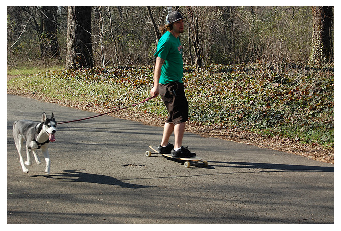

In [28]:
# load and display example image
# this iamge was also saved for sample image similarity computations
I = iio.imread('../../../data/val/val2014/%s'%(img['file_name']))
plt.axis('off')
plt.imshow(I)
plt.show()

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
[222259, 242536, 255565, 255925, 257224]
[{'image_id': 45175, 'id': 222259, 'caption': 'a man riding a skateboard with his dog.'}, {'image_id': 45175, 'id': 242536, 'caption': 'A man on a skateboard walks a dog on a leash.'}, {'image_id': 45175, 'id': 255565, 'caption': 'A boy on a skateboard walking a dog on a pavement.'}, {'image_id': 45175, 'id': 255925, 'caption': 'A man skateboarding while walking his dog. '}, {'image_id': 45175, 'id': 257224, 'caption': 'A man walking his dog while riding a skateboard'}]
a man riding a skateboard with his dog.
A man on a skateboard walks a dog on a leash.
A boy on a skateboard walking a dog on a pavement.
A man skateboarding while walking his dog. 
A man walking his dog while riding a skateboard


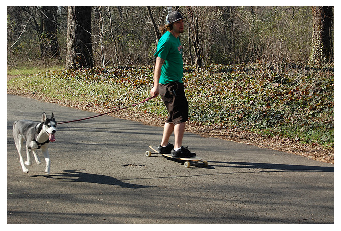

In [29]:
# initialize COCO api for caption annotations
coco_caps=COCO("../../../data/val/annotations/captions_val2014.json")

# load and display caption annotations for the selected image
annIds = coco_caps.getAnnIds(imgIds=img['id']);
print(annIds)
anns = coco_caps.loadAnns(annIds)
print(anns)

coco_caps.showAnns(anns)
plt.imshow(I); plt.axis('off'); plt.show()

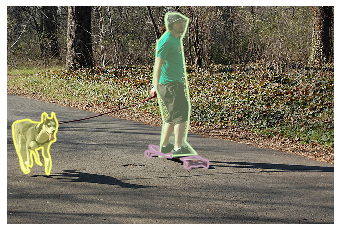

In [48]:
# load and display keypoint annotations, just for exploration
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

3   [47, 53, 54]
6   [715, 242605, 273711, 360209, 258290, 440377]
[812417, 814289, 815371, 815830, 817311]
[{'image_id': 258290, 'id': 812417, 'caption': 'A marble tabletop that has a coffee cup and saucer one one side and two plates of food on the other sides.'}, {'image_id': 258290, 'id': 814289, 'caption': 'Food sitting on plates and drink in a cup sitting on the table'}, {'image_id': 258290, 'id': 815371, 'caption': 'a plate of food on a table near a drink '}, {'image_id': 258290, 'id': 815830, 'caption': 'table set with a meal on white plates and tablecloth\n'}, {'image_id': 258290, 'id': 817311, 'caption': 'A meal with 2 plates and a cup of coffee.'}]

A marble tabletop that has a coffee cup and saucer one one side and two plates of food on the other sides.
Food sitting on plates and drink in a cup sitting on the table
a plate of food on a table near a drink 
table set with a meal on white plates and tablecloth

A meal with 2 plates and a cup of coffee.


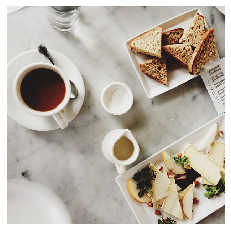

In [35]:
# try out a different example
catIds2 = coco.getCatIds(catNms=['apple', 'sandwich', 'cup']); 
imgIds2 = coco.getImgIds(catIds=catIds2);
print(len(catIds2), " ", catIds2)
print(len(imgIds2), " ", imgIds2)
# insert a random image ID from the ones displayed above for the given categories, in order to display it along with captions
imgIds2 = coco.getImgIds(imgIds = [258290])
img2 = coco.loadImgs(imgIds2)[0]
I2 = iio.imread('../../../data/val/val2014/%s'%(img2['file_name']))

# load and display caption annotations for the selected image
annIds2 = coco_caps.getAnnIds(imgIds=img2['id']);
print(annIds2)
anns2 = coco_caps.loadAnns(annIds2)
print(anns2)
print()

coco_caps.showAnns(anns2)
plt.imshow(I2); plt.axis('off'); plt.show()
# this second image is also saved and used for exploring image similarity


this is an image  of a child's birthday party.
Several children sitting at table with balloons attached to chairs.
A bunch of children are sitting at a birthday party
A long table surrounded by children with balloons
The children are eating together at the birthday party.


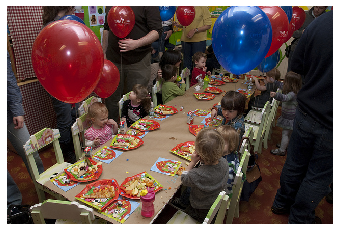

In [36]:
# get a different example with the same categories
imgIds3 = coco.getImgIds(imgIds = [242605])
img3 = coco.loadImgs(imgIds3)[0]
I3 = iio.imread('../../../data/val/val2014/%s'%(img3['file_name']))

# load and display caption annotations for the selected image
annIds3 = coco_caps.getAnnIds(imgIds=img3['id']);
anns3 = coco_caps.loadAnns(annIds3)
print()

coco_caps.showAnns(anns3)
plt.imshow(I3); plt.axis('off'); plt.show()

In [39]:
# out of interest, get all other categories associated with this image
img3_cats = [cat["category_id"] for cat in categories["annotations"] if cat["image_id"] == 242605]
set(img3_cats)

{1, 31, 44, 47, 53, 54, 57, 59, 62, 67}

From this exploration we can see that category annotations might be quite noisy in the sense that there might be many other more "dominant" categories from a visual point of view. This might be crucial to keep in mind for evaluating the text2image approach.

### Convenience scripts for loading and preparing dataset

For processing the full dataset python scripts will be used. This notebook serves mere exploratory and visualisation purposes. The scripts that have been created so far can be found under `src/utils`.

### Explore categorization
Since one of the main experiments includes pairing images from similar categories, the categorization structure of the dataset is explored. More specifically, since the categories are assigned to single objects / bounding boxes within the images, one needs a way to decide how many objects and distinct categories are allowed within two images to count as being from the same category (see counter example above). 

In [35]:
# import image 2 categories file
with open("../../../data/imageIDs_to_categories.json", "r", encoding="utf-8") as fp:
    images = json.load(fp)
len(images)    

40504

In [41]:
# get list of category lists 
img_cats = list(images.values())
# compute average nr of categories per image
cat_nr_per_image = [len(cats['categories']) for cats in img_cats]
sum(cat_nr_per_image) / len(cat_nr_per_image)

2.8785305155046417

Based on the small average number of categories per image, it might make sense to just drop images with many categories, or create a separate difficult split out of them. Given results below, I'd just drop images with more than 5 categories assigned.

In [42]:
# count the lengths of the category lists 
cats_counter = Counter(cat_nr_per_image)
sorted(cats_counter.items(), key=lambda item: item[1], reverse = True)

[(2, 12327),
 (1, 8398),
 (3, 8312),
 (4, 4734),
 (5, 2717),
 (6, 1630),
 (7, 922),
 (8, 531),
 (0, 367),
 (9, 286),
 (10, 146),
 (11, 71),
 (12, 42),
 (13, 14),
 (14, 5),
 (15, 2)]

In [43]:
# count the occurrences of the single categories
img_subcats = [cats["categories"] for cats in img_cats]
img_cats_flat = [cat for cat_list in img_subcats for cat in cat_list]
cats_abs_counter = Counter(img_cats_flat)
sorted(cats_abs_counter.items(), key = lambda item: item[1], reverse = True) # --> person is by far the most popular category
# check if categories missing below also aren't used here -- indeed
# sorted(cats_abs_counter.items(), key = lambda item: item[0])

[(1, 21634),
 (62, 4404),
 (3, 4180),
 (67, 3960),
 (47, 3061),
 (44, 2912),
 (51, 2397),
 (31, 2272),
 (8, 2056),
 (15, 1961),
 (27, 1832),
 (84, 1828),
 (85, 1704),
 (77, 1695),
 (72, 1577),
 (81, 1574),
 (64, 1540),
 (18, 1521),
 (17, 1480),
 (63, 1448),
 (37, 1445),
 (10, 1437),
 (49, 1410),
 (28, 1393),
 (6, 1350),
 (42, 1292),
 (65, 1292),
 (32, 1288),
 (7, 1281),
 (73, 1232),
 (4, 1219),
 (86, 1200),
 (43, 1193),
 (50, 1189),
 (70, 1185),
 (48, 1173),
 (16, 1121),
 (59, 1117),
 (2, 1114),
 (41, 1092),
 (9, 1048),
 (75, 1041),
 (19, 1001),
 (35, 993),
 (79, 989),
 (61, 969),
 (33, 876),
 (46, 872),
 (25, 849),
 (40, 845),
 (5, 840),
 (54, 818),
 (39, 799),
 (82, 790),
 (34, 757),
 (76, 750),
 (52, 728),
 (38, 727),
 (88, 724),
 (22, 714),
 (24, 677),
 (74, 674),
 (56, 670),
 (21, 666),
 (11, 592),
 (13, 589),
 (57, 578),
 (55, 568),
 (36, 533),
 (60, 523),
 (78, 512),
 (53, 491),
 (20, 489),
 (58, 452),
 (90, 341),
 (23, 341),
 (87, 302),
 (14, 261),
 (80, 74),
 (89, 70)]

In [17]:
# get the supercategories for each image's categories

# load annotations file
with open("../../../data/val/annotations/instances_val2014.json") as anns:
    supercategories_raw = json.load(anns)["categories"]


[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

In [34]:
# create a category 2 supercategory dict
cats_2_supercats = dict()
for i in list(range(1,91)):
    cats_2_supercats[str(i)] = list()
for cat in supercategories_raw:
    cats_2_supercats[str(cat["id"])] = cat["supercategory"]
    
cats_2_supercats
# export 
with open("../../../data/categories_to_supercategories.json", "w") as fp:
    json.dump(cats_2_supercats, fp)

In [44]:
# map categories to supercategories for each image
img_supercats = list()
for img in img_subcats:
    supercats = [cats_2_supercats[str(im)] for im in img]
    supercats = list(set(supercats))
    img_supercats.append(supercats)
img_supercats    

[['vehicle', 'person'],
 ['person', 'appliance', 'kitchen', 'food'],
 ['person', 'accessory', 'animal'],
 ['person', 'electronic'],
 ['person', 'electronic'],
 ['kitchen', 'appliance', 'furniture', 'person', 'food'],
 ['indoor',
  'kitchen',
  'food',
  'furniture',
  'person',
  'accessory',
  'animal',
  'appliance'],
 ['person', 'kitchen', 'furniture'],
 ['kitchen', 'appliance'],
 ['kitchen', 'accessory', 'person'],
 ['kitchen', 'person', 'appliance', 'furniture'],
 ['kitchen', 'indoor', 'appliance', 'furniture'],
 ['kitchen', 'appliance'],
 ['appliance', 'furniture'],
 ['vehicle', 'outdoor', 'person'],
 ['kitchen', 'appliance'],
 ['indoor',
  'kitchen',
  'electronic',
  'food',
  'furniture',
  'outdoor',
  'appliance'],
 ['kitchen', 'person', 'appliance', 'food'],
 ['kitchen', 'indoor', 'appliance'],
 ['sports', 'vehicle', 'furniture', 'person', 'accessory'],
 ['appliance'],
 ['food', 'appliance', 'furniture'],
 ['vehicle', 'accessory', 'person'],
 ['kitchen', 'furniture'],
 ['ki

In [32]:
# get average number of supercats per image
supercat_nr_per_image = [len(cats) for cats in img_supercats]
sum(supercat_nr_per_image) / len(supercat_nr_per_image)

2.291971163341892

Based on the explorations above, the idea would be to drop / exclude as too crowded all images with more than 6 subcategories assigned to them. For more than three subcategory images, only use them if the supercategories are identical. For easier checking, a flag `has_many_categories` was added to the image2categories dictionary. It will be checked how many images this would exclude. These considerations need to be taken when building the dataset for the within-category experiment. 

## Explore  captions structure

The following part explores the frequency of the tokens in the captions and the need for preprocessing the captions for pretraining and reference game training. 

In [2]:
from torchtext.data import get_tokenizer
import seaborn as sns

In [3]:
with open("../../../data/train/annotations/captions_train2014.json") as f:
    train_captions = json.load(f)

In [4]:
print(len(train_captions["annotations"]))
print(len(train_captions["images"]))

414113
82783


In [5]:
tokenizer = get_tokenizer("basic_english")

avg_cap_length = [len(tokenizer(cap["caption"])) for cap in train_captions["annotations"]]
print("Average caption length: ", sum(avg_cap_length)/len(avg_cap_length))

Average caption length:  11.313559342498303


In [6]:
# explore the lengths distribution
len_counter = Counter(avg_cap_length)
len_counter_desc = sorted(len_counter.items(), key=lambda item: item[1], reverse = True)
len_counter_vals = [val[1] for val in len_counter_desc]
len_counter_desc

[(10, 85868),
 (11, 79750),
 (9, 71789),
 (12, 57631),
 (13, 37774),
 (14, 22558),
 (8, 20752),
 (15, 12979),
 (16, 7869),
 (17, 4966),
 (18, 3160),
 (19, 2027),
 (7, 1592),
 (20, 1445),
 (21, 1010),
 (22, 692),
 (23, 538),
 (24, 388),
 (25, 280),
 (26, 207),
 (27, 162),
 (28, 113),
 (29, 73),
 (30, 63),
 (31, 56),
 (34, 43),
 (32, 42),
 (33, 31),
 (37, 30),
 (35, 28),
 (36, 27),
 (38, 19),
 (43, 18),
 (39, 16),
 (44, 15),
 (40, 11),
 (45, 10),
 (48, 10),
 (46, 10),
 (47, 9),
 (51, 8),
 (42, 8),
 (49, 7),
 (41, 7),
 (52, 6),
 (50, 5),
 (56, 2),
 (6, 2),
 (53, 2),
 (57, 2),
 (55, 2),
 (54, 1)]

<AxesSubplot:ylabel='Density'>

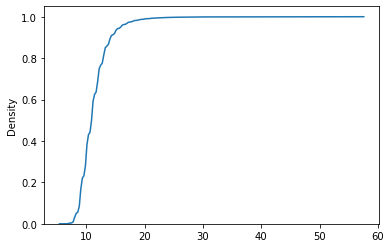

In [7]:
# plt.plot(list(range(0, len(len_counter_vals))), len_counter_vals)
# plt.show()
sns.kdeplot(avg_cap_length, cumulative=True)

In [8]:
# check the proportion of captions covered at lengths for every 5 steps
count_all_len= sum(len_counter_vals)
for i in range(1, 11):
    idx = i*5
    prop = sum(len_counter_vals[:idx])/count_all_len
    print("Proportion of captions covered at lenth ", idx, " is: ", prop)

Proportion of captions covered at lenth  5  is:  0.8036743594139764
Proportion of captions covered at lenth  10  is:  0.9705949825289233
Proportion of captions covered at lenth  15  is:  0.9928932441145292
Proportion of captions covered at lenth  20  is:  0.9979763977465088
Proportion of captions covered at lenth  25  is:  0.9991041092648625
Proportion of captions covered at lenth  30  is:  0.9995242844344419
Proportion of captions covered at lenth  35  is:  0.9997536904178328
Proportion of captions covered at lenth  40  is:  0.9998744304090912
Proportion of captions covered at lenth  45  is:  0.9999613632027973
Proportion of captions covered at lenth  50  is:  0.9999927556005245


More than 99% of the captions in the train dataset have a length of 15 tokens or less, such that the captions will be truncated to 15 tokens for training the models. 

In [11]:
# explore the distribution of tokens using the torch default tokenizer

counter = Counter()
caps = train_captions["annotations"]
for i, id in enumerate(caps):
    caption = str(caps[i]['caption'])
    tokens = tokenizer(caption.lower()) 
    counter.update(tokens)

#     if i % 100000 == 0:
#         print("[%d/%d] Tokenizing captions..." % (i, len(ids)))



In [23]:
# there would be 2009 words if thresholding at 93, 6067 if thresholding at 11
words = [word for word, cnt in counter.items() if cnt >= 93]
len(words)

2009

In [43]:
print("Number of unique tokens: ", len(words))
freq_desc = sorted(counter.items(), key=lambda item: item[1], reverse = True)
# check how frequent the tokens every 1000 steps are
for i in range(1, 25):
    idx = i * 1000
    print("Frequency at ", idx, " is: ", freq_desc[idx][1])

Number of unique tokens:  24697
Frequency at  1000  is:  307
Frequency at  2000  is:  93
Frequency at  3000  is:  44
Frequency at  4000  is:  25
Frequency at  5000  is:  16
Frequency at  6000  is:  11
Frequency at  7000  is:  8
Frequency at  8000  is:  6
Frequency at  9000  is:  4
Frequency at  10000  is:  3
Frequency at  11000  is:  3
Frequency at  12000  is:  2
Frequency at  13000  is:  2
Frequency at  14000  is:  2
Frequency at  15000  is:  1
Frequency at  16000  is:  1
Frequency at  17000  is:  1
Frequency at  18000  is:  1
Frequency at  19000  is:  1
Frequency at  20000  is:  1
Frequency at  21000  is:  1
Frequency at  22000  is:  1
Frequency at  23000  is:  1
Frequency at  24000  is:  1


In [50]:
# check the frequency at 500 - the count is around 1000
freq_desc[500]

('windows', 929)

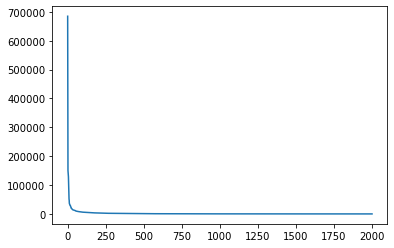

In [51]:
frequencies = [fr[1] for fr in freq_desc]

plt.plot(list(range(0, len(frequencies[:2000]))), frequencies[:2000])
plt.show()

In [54]:
# compute the proportions of the dataset covered if i were to cut at the 1000 steps
count_all = sum(frequencies)
for i in range(1, 25):
    idx = i*1000
    prop = sum(frequencies[:idx])/count_all
    print("Proportion of occurences covered at idx ", idx, " is: ", prop)

Proportion of occurences covered at idx  1000  is:  0.9255805435624317
Proportion of occurences covered at idx  2000  is:  0.9622974319394368
Proportion of occurences covered at idx  3000  is:  0.9761586325305885
Proportion of occurences covered at idx  4000  is:  0.9832861339755975
Proportion of occurences covered at idx  5000  is:  0.9875712152504156
Proportion of occurences covered at idx  6000  is:  0.990370733381543
Proportion of occurences covered at idx  7000  is:  0.9923090090866946
Proportion of occurences covered at idx  8000  is:  0.9937134638978274
Proportion of occurences covered at idx  9000  is:  0.9947653109053142
Proportion of occurences covered at idx  10000  is:  0.9956047821472876
Proportion of occurences covered at idx  11000  is:  0.9962451110885336
Proportion of occurences covered at idx  12000  is:  0.9967725286931398
Proportion of occurences covered at idx  13000  is:  0.9971994146539706
Proportion of occurences covered at idx  14000  is:  0.9976263006148012
Pr

In [56]:
# --> If cutting at 2000 most frequent tokens, more than 95% of word occurrences would be covered; 
# if cutting at 6000 it would be over 99%

# get the thresholds
threshold_2000 = freq_desc[2000][1]
threshold_6000 = freq_desc[6000][1]
print(threshold_2000, threshold_6000)

93 11


In [99]:
import unicodedata
import re

# from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# not necessary here, isn't being applied
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

bad_sents = []
def normalizeString(orig_sent):
    s = orig_sent.lower().strip() # unicodeToAscii
#     s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.,!?]+", r" ", s)
    if not orig_sent.lower().strip() == s:
        bad_sents.append(orig_sent)
    return orig_sent.lower().strip() == s

sents = [cap['caption'] for cap in caps]

In [100]:
sent_transforms = [normalizeString(s) for s in sents]

In [101]:
print("Proportion of sentences which don't have to be normalize")
sum(sent_transforms)/ len(sent_transforms)

Proportion of sentences which don't have to be normalize


0.9612424628060456

In [102]:
print("Number of sentences containing punctuation which will be substituted: ", len(bad_sents))

Number of sentences containing punctuation which will be substituted:  16050
